# Import Libraries

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
from art.utils import load_mnist
tf.compat.v1.disable_eager_execution()

# Load Dataset

In [30]:
(X_train, y_train), (X_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [31]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [32]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [6]:
#X_train = X_train.reshape((60000, 28, 28, 1)).astype("float32")
#X_test = X_test.reshape((10000, 28, 28, 1)).astype("float32")

In [7]:
#X_train = X_train / 255
#X_test = X_test / 255

In [8]:
#import numpy as np
#import pandas as pd
#from keras.utils.np_utils import to_categorical
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

# Model

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

In [34]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               589952    
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                      

# Train

In [36]:
from art.estimators.classification import KerasClassifier
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

In [37]:
classifier.fit(X_train, y_train, batch_size=64, nb_epochs=3)

Train on 60000 samples
Epoch 1/3


2023-08-20 01:06:26.019158: W tensorflow/c/c_api.cc:300] Operation '{name:'training_4/Adam/dense_8/bias/m/Assign' id:1621 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_8/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_8/bias/m, training_4/Adam/dense_8/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 11s 184us/sample - loss: 0.1704 - accuracy: 0.9497
Epoch 2/3
60000/60000 [==============================] - 11s 180us/sample - loss: 0.0586 - accuracy: 0.9820
Epoch 3/3
60000/60000 [==============================] - 11s 180us/sample - loss: 0.0395 - accuracy: 0.9877


In [38]:
y_pred = classifier.predict(X_test)

/home/alper/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-20 01:11:07.206907: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_9/Softmax' id:1354 op device:{requested: '', assigned: ''} def:{{{node dense_9/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_9/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [39]:
def calc_accuracy(preds):
    acc = np.sum(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    return acc

In [40]:
accuracy = calc_accuracy(y_pred)

In [43]:
print(f"Accuracy before attack: {accuracy * 100: .2f}%")

Accuracy before attack:  98.51%


# Attack

In [44]:
from art.attacks.evasion import FastGradientMethod
fgsm = FastGradientMethod(estimator=classifier, eps=0.2)

In [46]:
X_test_adversarial = fgsm.generate(x=X_test)

In [47]:
adv_pred = classifier.predict(X_test_adversarial)

In [48]:
adv_accuracy = calc_accuracy(adv_pred)

In [49]:
print(f"Accuracy after attack: {adv_accuracy * 100: .2f}%")

Accuracy after attack:  9.71%


In [51]:
- (98.51 - 9.71)

-88.80000000000001

In [52]:
import matplotlib.pyplot as plt

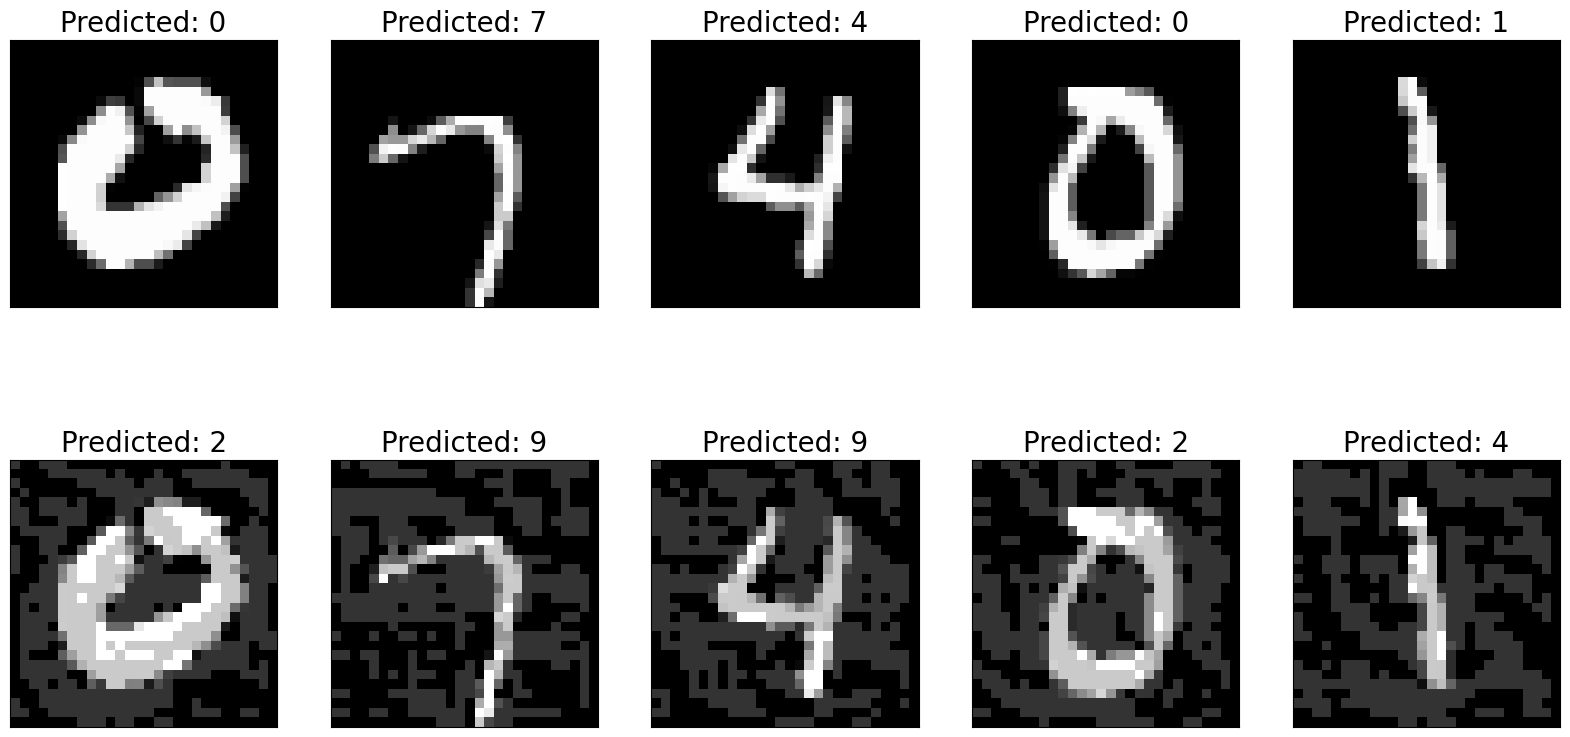

In [78]:
plt.figure(figsize= (20,10))

for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i+25,:,:,:], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Predicted: {y_pred[i+25].argmax()}", fontsize=20)
    
    ax = plt.subplot(2, 5, i+1+5)
    plt.imshow(X_test_adversarial[i+25,:,:,:], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(y_test[i].argmax())
    ax.set_title(f"Predicted: {adv_pred[i+25].argmax()}", fontsize=20)
    
plt.show()